In [20]:
import os
import networkx as nx
import dill as pickle
import matplotlib
import matplotlib.pyplot as plt
from io import BytesIO
from PIL import Image
import numpy as np
import seaborn as sns

matplotlib.rc('font',family='serif', serif=['Palatino'])
sns.set(font='serif', font_scale=1.4)
sns.set_style("white", {
        "font.family": "serif",
        "font.weight": "normal",
        "font.serif": ["Times", "Palatino", "serif"],
        'axes.facecolor': 'white',
        'lines.markeredgewidth': 1})

In [21]:
def visualize_graph(graph, graph_file="", number_nodes=False):
    """Visualizes the graph by saving to file or displaying.
    
    Parameters:
        graph (nx.DiGraph)
            The graph to visualize.
        graph_file (str)
            The name of the file to save the graph to. If empty, the graph is displayed.
        number_nodes (bool)
            Whether to number the nodes in the graph.

    Side Effects:
        - Creates temporary image files
        - Modifies the graph's labels and images
        - Saves the graph to a file
    """
    for i, node in enumerate(graph.nodes):
        graph.nodes[node]["fontsize"] = "60"
        graph.nodes[node]["label"] = str(i) if number_nodes else ""
        model = graph.nodes[node]["model"]
        graph.nodes[node]["image"] = model.get_image_path()
    for edge in graph.edges:
        graph[edge[0]][edge[1]]["label"] = str(graph[edge[0]][edge[1]]["action"])
    pygraphviz_graph = nx.nx_agraph.to_agraph(graph)
    pygraphviz_graph.layout('dot')
    # Add more whitespace around the nodes but keep the same size
    pygraphviz_graph.graph_attr.update({'nodesep': 1.0, 'ranksep': 1.0})
    if graph_file:
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(graph_file), exist_ok=True)
        pygraphviz_graph.draw(graph_file)
    else:
        img = Image.open(BytesIO(pygraphviz_graph.draw(format='png')))
        plt.imshow(img)
        plt.show()

In [22]:
# Load and visualize a pygraphviz graph
filename = "outputs/2024-05-16/20-59-00/BW-rand-4_instance-35/graph_lazy.pkl"

with open(filename, "rb") as f:
    G = pickle.load(f)

visualize_graph(G, graph_file="data/viz/graph.png")

In [23]:
from viz_script import get_stats

names = [
    "Boomerang",
    "ToI-DFS",
    "ToI-BFS",
    "ReAct",    
    "Fast Downward"
]

log_dirs = [
    "data/final/boomerang", # Boomerang
    "data/final/ToI-DFS", # ToI-DFS
    "data/final/ToI-BFS", # ToI-BFS
    "data/final/ReAct", # ReAct
    "data/final/fastdownward", # Fast Downward
]
results_csv = 'results.csv'
log_files = [
    'log_lazy.txt',
    'log_tot_dfs.txt',
    'log_tot_bfs.txt',
    'log_ReAct.txt',
    'log_fd.txt',
]
hydra_log_file = 'main_script.log'

stats = {}
for name, log_dir, log_file in zip(names, log_dirs, log_files):
    df, llm_calls, llm_token_usage = get_stats(log_dir, results_csv, log_file, hydra_log_file)
    stats[name] = (df, llm_calls, llm_token_usage)

    print("Printing stats for", log_dir)
    success_df = df[df["reached_goal"] == True]
    success_df = df[(df["reached_goal"] == True) & (df["total_edges_expanded"] <= 20)]
    print(f"Success rate: {len(success_df)} / {len(df)}")
    print(f"Average nodes expanded: {df['total_nodes_expanded'].mean()}")
    print(f"Median nodes expanded: {df['total_nodes_expanded'].median()}")
    print(f"Std nodes expanded: {df['total_nodes_expanded'].std()}")
    print(f"Average edges expanded: {df['total_edges_expanded'].mean()}")
    print(f"Median edges expanded: {df['total_edges_expanded'].median()}")
    print(f"Std edges expanded: {df['total_edges_expanded'].std()}")
    print(f"LLM calls per run: {llm_calls / len(df)}")
    print(f"LLM token usage: {llm_token_usage / len(df)}")
    print('\n\n')

Printing stats for data/final/boomerang
Success rate: 511 / 600
Average nodes expanded: 10.783333333333333
Median nodes expanded: 9.0
Std nodes expanded: 5.450005488247276
Average edges expanded: 10.401666666666667
Median edges expanded: 9.0
Std edges expanded: 6.070564235647355
LLM calls per run: 5.691666666666666
LLM token usage: 38235.725



Printing stats for data/final/ToI-DFS
Success rate: 139 / 325
Average nodes expanded: 12.978461538461538
Median nodes expanded: 14.0
Std nodes expanded: 5.79454011606574
Average edges expanded: 18.64923076923077
Median edges expanded: 20.0
Std edges expanded: 9.576207061796875
LLM calls per run: 28.31692307692308
LLM token usage: 23453.996923076924



Printing stats for data/final/ToI-BFS
Success rate: 174 / 600
Average nodes expanded: 16.685
Median nodes expanded: 14.0
Std nodes expanded: 9.969190016377345
Average edges expanded: 24.76
Median edges expanded: 21.0
Std edges expanded: 16.391263604053307
LLM calls per run: 39.57833333333333
LLM to

In [24]:
def plot_success_rate_bar_graph(algorithms, success_rates):
    # Define a base color
    base_color = plt.cm.Blues

    # Normalize success rates to range [0, 1] for color mapping
    norm = plt.Normalize(min(success_rates), max(success_rates))

    # Create the bar plot
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.bar(algorithms, success_rates, color=base_color(norm(success_rates)), edgecolor='black', linewidth=1.2)

    # Add titles and labels
    ax.set_title('Success over PlanBench', fontsize=16, weight='bold')
    ax.set_xlabel('Algorithms', fontsize=14)
    ax.set_ylabel('Success Rate', fontsize=14)

    # Customize tick parameters
    ax.tick_params(axis='both', which='major', labelsize=12)

    # Set y-axis range from 0 to 1
    ax.set_ylim(0, 1)

    # Add value labels on top of the bars
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', 
                ha='center', va='bottom', fontsize=12, color='black', weight='bold')

    # Remove spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Customize grid lines
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.7, alpha=0.7)
    ax.set_axisbelow(True)

    # Show plot
    plt.tight_layout()
    plt.show()

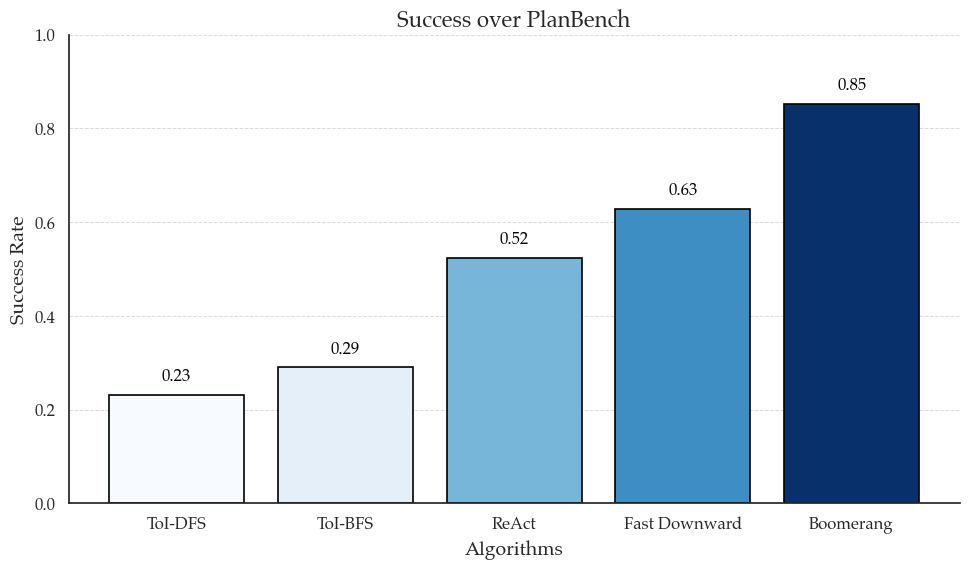

In [25]:
# Plot the success rate of each algorithm as a bar chart in ascending order of success
# Make the x-axis labels the algorithm names
# Make the y-axis label the success rate out of 600

success_rates = []
for name in names:
    df = stats[name][0]
    success_df = df[(df["reached_goal"] == True) & (df["total_edges_expanded"] <= 20)]
    success_rates.append(len(success_df) / 600) # TODO: Change to 600 when run on rest of data
sorted_names = [name for _, name in sorted(zip(success_rates, names))]
sorted_success_rates = sorted(success_rates)

plot_success_rate_bar_graph(sorted_names, sorted_success_rates)


In [26]:
def plot_grouped_comparison(frequencies, names, overlayed_frequencies=None, x_bounds=(1, 20), y_label='Frequency'):
    """
    Plots a grouped comparison of histograms.

    Parameters:
    - frequencies: List of arrays containing the frequencies for each histogram.
    - names: List of names/titles for each histogram.
    - overlayed_frequencies: Array containing the frequencies for the overlayed histogram (default is None).
    - x_bounds: Tuple containing the lower and upper bounds for the x-axis (default is (1, 20)).
    """
    # Create subplots
    fig, axes = plt.subplots(figsize=(14, 5), ncols=len(frequencies), sharey=True)

    # Colors for histograms
    base_colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']

    # Plot each histogram
    for i, ax in enumerate(axes):
        ax.bar(np.arange(x_bounds[0], x_bounds[1]+1), frequencies[i], color=base_colors[i], edgecolor='black', width=1, alpha=1.0)

        # Overlay one histogram for comparison
        if overlayed_frequencies is not None:
            ax.bar(np.arange(x_bounds[0], x_bounds[1]+1), overlayed_frequencies, color='skyblue', edgecolor='black', width=1, alpha=0.5)

        # Set labels
        ax.set_title(names[i], fontsize=12, fontweight='bold')
        ax.set_xlabel('Query-bound', fontsize=10)
        ax.set_xlim(x_bounds[0] - 0.5, x_bounds[1] + 0.5)
        ax.set_xticks(np.arange(x_bounds[0], x_bounds[1]+1, 10))
        if i == 0:
            ax.set_ylabel(y_label, fontsize=10)

    # Adjust layout
    plt.tight_layout()
    plt.show()

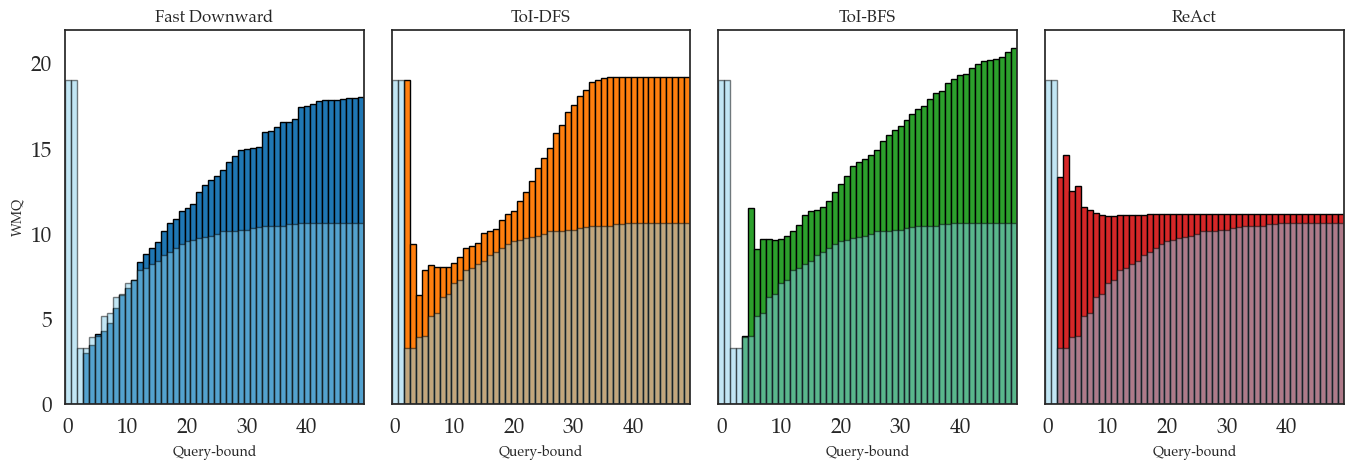

In [27]:
# Plot WMQ overlayed histograms

plot_names = ['Fast Downward', 'ToI-DFS', 'ToI-BFS', 'ReAct', 'Boomerang']
frequencies = []
overlayed_frequencies = None
bounds = (0, 50)
for name in plot_names:
    frequency = []
    for bound in range(*bounds):
        df = stats[name][0]
        success_df = df[(df["total_edges_expanded"] <= bound)]
        # If total edges expanded is less than the optimal plan length, penalize w/ decision-steps - 1
        success_df.loc[success_df['total_edges_expanded'] < (success_df['optimal_length'] - 1), 'total_edges_expanded'] = 19
        
        average_wmq = success_df['total_edges_expanded'].mean() if len(success_df) > 0 else 0
        frequency.append(average_wmq)
    if name == "Boomerang":
        overlayed_frequencies = frequency
    else:
        frequencies.append(frequency)

# Sort such that Fast Downward is first and Boomerang is last
x_bounds = (bounds[0], bounds[1] - 1)
plot_grouped_comparison(frequencies, plot_names, overlayed_frequencies, x_bounds, 'WMQ')

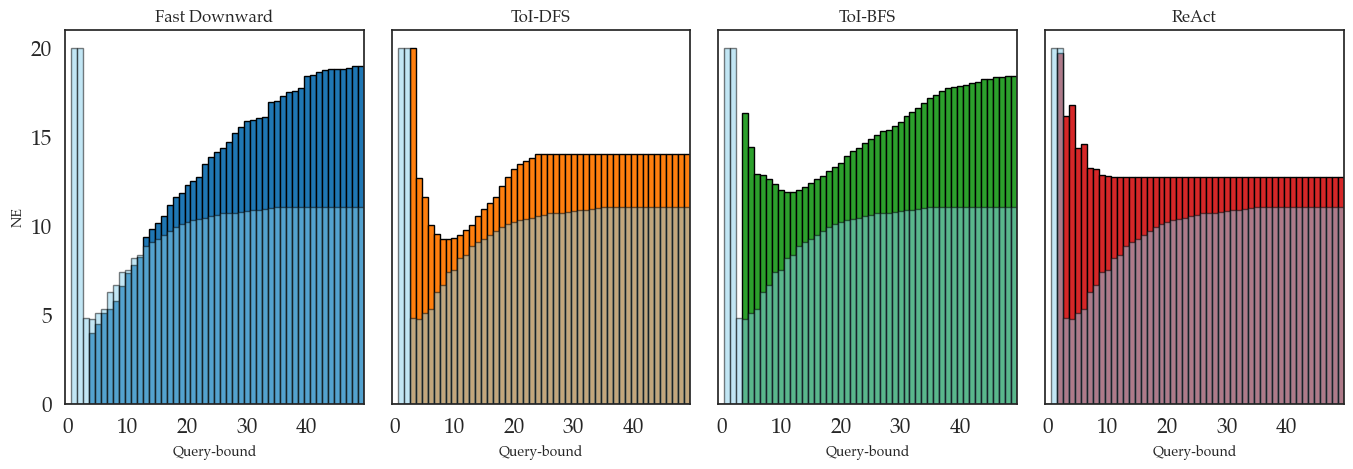

In [28]:
# Plot NE overlayed histograms

plot_names = ['Fast Downward', 'ToI-DFS', 'ToI-BFS', 'ReAct', 'Boomerang']
frequencies = []
overlayed_frequencies = None
bounds = (0, 50)
for name in plot_names:
    frequency = []
    for bound in range(*bounds):
        df = stats[name][0]
        success_df = df[(df["total_nodes_expanded"] <= bound)]
        # If total edges expanded is less than the optimal plan length, set edges to 20
        success_df.loc[success_df['total_nodes_expanded'] < success_df['optimal_length'], 'total_nodes_expanded'] = 20
        average_ne = success_df['total_nodes_expanded'].mean() if len(success_df) > 0 else 0
        frequency.append(average_ne)
    if name == "Boomerang":
        overlayed_frequencies = frequency
    else:
        frequencies.append(frequency)

# Sort such that Fast Downward is first and Boomerang is last
x_bounds = (bounds[0], bounds[1] - 1)
plot_grouped_comparison(frequencies, plot_names, overlayed_frequencies, x_bounds, 'NE')

In [29]:
df = stats["ReAct"][0]

print(df['optimal_length'].mean())
print(df['total_edges_expanded'].mean())

# Get unique counts of optimal plan length for ReAct's successes
success_df = df[(df["reached_goal"] == True) & (df["total_edges_expanded"] <= 20)]
unique, counts = np.unique(success_df["optimal_length"], return_counts=True)
unique_counts = dict(zip(unique, counts))
print("ReAct Stats")
print(f"Successes: {len(success_df)}")
print(f"Success Distribution (optimal length: count) {unique_counts}")
print(f"Average Optimal Plan Length: {success_df['optimal_length'].mean()}")
print(f"Std Optimal Plan Length: {success_df['optimal_length'].std()}")
print(f"Average Edges Expanded: {success_df['total_edges_expanded'].mean()}")

df = stats["Boomerang"][0]

# Get unique counts of optimal plan length for Boomerang's successes
success_df = df[(df["reached_goal"] == True) & (df["total_edges_expanded"] <= 20)]
unique, counts = np.unique(success_df["optimal_length"], return_counts=True)
unique_counts = dict(zip(unique, counts))
print("Boomerang Stats")
print(f"Successes: {len(success_df)}")
print(f"Success Distribution (optimal length: count) {unique_counts}")
print(f"Average Optimal Plan Length: {success_df['optimal_length'].mean()}")
print(f"Std Optimal Plan Length: {success_df['optimal_length'].std()}")
print(f"Average Edges Expanded: {success_df['total_edges_expanded'].mean()}")

7.153333333333333
6.065
ReAct Stats
Successes: 314
Success Distribution (optimal length: count) {2: 43, 4: 68, 6: 107, 8: 66, 10: 28, 12: 2}
Average Optimal Plan Length: 5.834394904458598
Std Optimal Plan Length: 2.3546490856167246
Average Edges Expanded: 6.745222929936306
Boomerang Stats
Successes: 511
Success Distribution (optimal length: count) {2: 45, 4: 82, 6: 146, 8: 123, 10: 81, 12: 32, 14: 1, 16: 1}
Average Optimal Plan Length: 6.853228962818004
Std Optimal Plan Length: 2.7224528200277702
Average Edges Expanded: 8.956947162426614


In [36]:
def stacked_bar_plot(data, categories, labels, title='Stacked Bar Plot', ylabel='Values'):
    """
    Create a stacked bar plot with dynamic number of categories.

    Parameters:
    data (2D list or numpy array): The data to plot, each inner list/array represents a bar.
                                   Shape should be (n_bars, n_categories).
    categories (list of str): The names of the categories.
    labels (list of str): The labels for each bar.
    title (str): The title of the plot.
    ylabel (str): The label for the y-axis.

    Example:
    data = [[5, 10, 15], [7, 14, 21], [3, 6, 9]]
    categories = ['Category 1', 'Category 2', 'Category 3']
    labels = ['Bar 1', 'Bar 2', 'Bar 3']
    """
    
    # Convert data to numpy array for easier manipulation
    data = np.array(data)
    
    # Get number of bars and number of categories
    num_bars, num_categories = data.shape
    
    # Set up the figure and axis
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Create the bars for each category
    bar_width = 0.6
    indices = np.arange(num_bars)
    
    # Initialize the bottom array
    bottom = np.zeros(num_bars)
    
    # Define colors for categories
    colors = ['#4CAF50', '#87CEEB', '#4682B4'] 
    
    # Plot each category
    for i in range(num_categories):
        p = plt.bar(indices, data[:, i], bar_width, bottom=bottom, label=categories[i], color=colors[i])
        
        # Add value annotations to the bars
        for rect in p:
            height = rect.get_height()
            if height > 0:
                ax.annotate('{:.0f}'.format(height),
                            xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                            xytext=(0, 0),  # No offset
                            textcoords="offset points",
                            ha='center', va='center', fontsize=10, color='black', weight='bold')

        bottom += data[:, i]

    # Add labels, title and legend
    # ax.set_xlabel('Bars')
    ax.set_ylabel(ylabel)
    ax.set_title(title)
    ax.set_xticks(indices)
    ax.set_xticklabels(labels)
    ax.legend()

    # Fix legend so no overlapping occurs
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
    # Display the plot
    plt.tight_layout()
    plt.show()

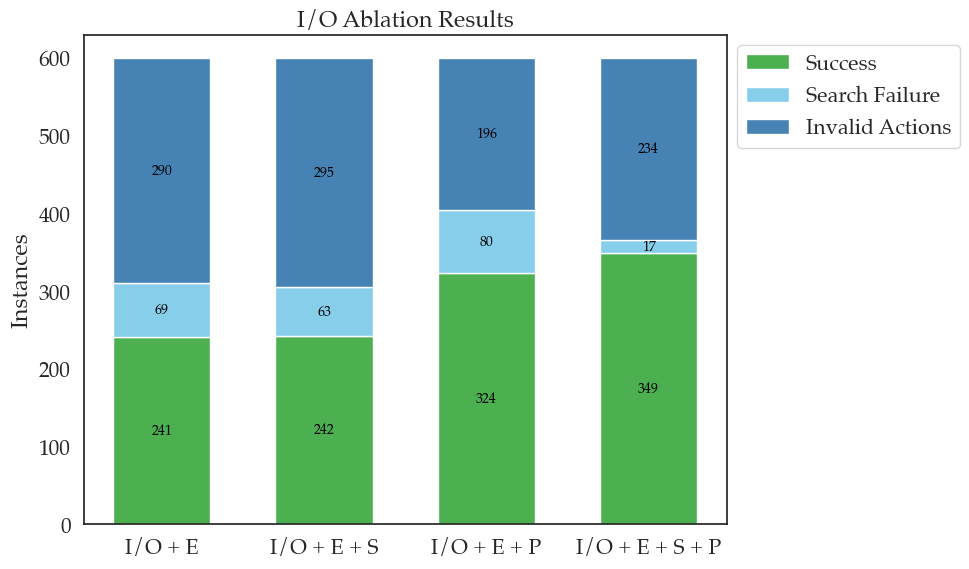

In [37]:
# I/O Ablation Results
categories = ['Success', 'Search Failure', 'Invalid Actions']
results = [
    ('I/O + E', [241, 69, 290]),
    ('I/O + E + S', [242, 63, 295]),
    ('I/O + E + P', [324, 80, 196]),
    ('I/O + E + S + P', [349, 17, 234])
]
labels, data = zip(*results)
stacked_bar_plot(data, categories, labels, title='I/O Ablation Results', ylabel='Instances')

# Get current Matplotlib font